In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.artist as artist
import matplotlib.patches as patches
from functools import *
from math import *
import pandas as pd
import time
import random
from IPython import display

%matplotlib inline

In [97]:
plt.style.use('ggplot')

In [98]:
size = 4

numNodes = 10
c_v = 0.01

############## ranges subject to change ###########
# communication range
r = 2
# sensing range
r_s = 1.6

# generate random points
points = size*np.random.rand(2, numNodes)

In [99]:
########################### build graph #########################

# add edge to graph (adding neighbors)
def addEdge(graph, pointIndex, neighborIndex):
    if pointIndex in graph:
        graph[pointIndex].append(neighborIndex)
    else:
        graph[pointIndex] = [neighborIndex]

def distance(point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    return (x1-x2)**2+(y1-y2)**2

# go through all nodes to see if neighbor
def findNeighbors(nodeIndex, n, q):
    
    neighborList = []
    q_i = np.array(q[nodeIndex-1]).ravel()

    centerX, centerY = q_i[0], q_i[1]
    for j in range(nodeIndex, n):
        q_j = np.array(q[j]).ravel()
        pointX, pointY = q_j[0], q_j[1]
        if distance((centerX, centerY), (pointX, pointY)) < r**2:
            neighborList.append(j+1)
    return neighborList

# dict[node number] = [neighbors]
# nodes with neighbors
def buildGraph(n, q):
    global fignum
    
    graph = dict()
    
    for i in range(1, n+1):
        centerIndex = i
        q_i = np.array(q[i-1]).ravel()
        centerX, centerY = q_i[0], q_i[1]
        neighbors = findNeighbors(centerIndex, n, q)
        for neighborIndex in neighbors:
            neighbor = neighborIndex-1
            
            q_j = np.array(q[neighbor]).ravel()
            
            pointX, pointY = q_j[0], q_j[1]
            # 3. Link sensor node with neighbor
            plt.plot([centerX, pointX], [centerY, pointY], color='b')
            # add 2 edges for undirected graph
            addEdge(graph, centerIndex, neighborIndex)
            addEdge(graph, neighborIndex, centerIndex)   
        if centerIndex not in graph:
            graph[centerIndex] = []
    
    return graph

def showSensorNodeGraph(x, y, n):
    fig = plt.figure()
    ax = fig.add_subplot(111)
 
    plt.scatter(2, 2, marker='o', color='blue')
    
    # q: node positions in matrix form
    q = np.column_stack((x, y))
    q = list(map(np.matrix, q))
    
    plt.scatter(x, y,
                marker='>',
                color='magenta')
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 4])
    # find neighbors for each node
    return buildGraph(n, q)

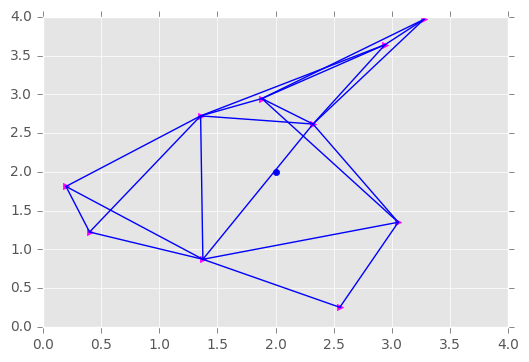

In [100]:
nodes = showSensorNodeGraph(points[0], points[1], numNodes)

In [101]:
#################### Supplemental Functions ########################

def euclideanNorm(q_i, q_j):
    return sqrt(np.sum(np.square(np.subtract(q_i, q_j))))

def sigmaNorm(z, epsilon):
    return 1/epsilon*(sqrt(1+epsilon*(z**2))-1)

# Noise variance model
def V_ik_t(q_i, q_ck):
    z = euclideanNorm(q_i, q_ck)
    if z <= r_s:
        return z**2+c_v/r_s**2
    else:
        return 0

V1 = []
# noise
n1 = []
# node measurements
m1 = []

V = []
n = []
m = []

groundTruthMeasurement = 50
groundTruthLoc = [2, 2]

# m_i = F_1 + n_i
# Add noise, N = 10
def measurement():
    # q: node positions in matrix form
    q = np.column_stack((points[0], points[1]))
    q = list(map(np.matrix, q))
    q_mean = reduce(np.add, q)/numNodes
    
    for i in range(numNodes):
        V1.append(((np.linalg.norm(np.subtract(q[i], q_mean))**2)+c_v)/(r_s**2))
        n1.append(np.random.normal(0.0, V1[i]))
        m1.append(groundTruthMeasurement + n1[i])
        
# observation at cell k at time step t based on its own confidence
# (weight) - cell weight
measurement()
m.append(m1)
n.append(n1)
V.append(V1)

In [102]:
########################### CASE 1 ################################
############ Estimate single cell (single scalar value) ###########

# iniital 
consensus = []
consensus.append(m1)

def compute_c1_w():
    numerator = 2*c_v
    N = numNodes-1
    denominator = N*r_s**2
    return numerator/denominator

def compute_c2_w():
    return c_v/(r_s**2)

def random_float(low, high):
    return random.random()*(high-low) + low

c1_w = random_float(0,compute_c1_w())
c2_w = random_float(0, compute_c2_w())



def weightDesign_1(q, i, j):
    if i != j:
        result = c1_w/(V1[i-1]+V1[j-1])
    else:
        result = 1
        for neighbor in findNeighbors(i, numNodes, q):
            result -= weightDesign_1(q, i, neighbor)
    return result

def weightDesign_2(q, i, j):
    if i == j:
        result = c2_w/V1[i-1]
    else:
        result = (1-weightDesign_2(q, i, i))/(numNodes-1)
        
    return result

# q: node positions in matrix form
q = np.column_stack((points[0], points[1]))
q = list(map(np.matrix, q))

nodeNumList = np.arange(1, numNodes+1, 1)
w_ij_1 = []


# every time step change topology - make sure connectivity is 1
#print(w_ij_1)

In [103]:
w_ij_2 = []
val = list(map(partial(weightDesign_2, q), nodeNumList, nodeNumList))
w_ij_2.append(val)

# every time step change topology - make sure connectivity is 1
#print(w_ij_2)

# average measurement only by nodes that have measurement
def consensus_update(t):
    #w_ij[t]*consensus[t]
    #print(len(w_ij_1[t]))
    #print(len(consensus[t]))
    val = list(map(partial(weightDesign_1, q), nodeNumList, nodeNumList))
    w_ij_1.append(val)
    return [a*b for a, b in zip(w_ij_1[t], consensus[t])]

#t = 0    
#print(w_ij_1[t])
#print(consensus[t])
for t in range(100):
    consensus.append(consensus_update(t))
    
print(consensus)

[[48.04987388926596, 48.44205977594021, 51.72838107135756, 50.27668359973395, 49.901146017831024, 50.046512599029676, 49.862224031552195, 52.052356998002466, 49.49226606535016, 49.64682686808065], [48.006818544443234, 48.339302169321293, 51.715351560812117, 50.210224523229058, 49.716980193983247, 49.950255499529554, 49.843040128206404, 52.052356998002466, 49.49226606535016, 49.64682686808065], [47.963801779591023, 48.236762537036391, 51.70232533218158, 50.143853296767837, 49.533494054939929, 49.854183536390046, 49.823863605641449, 52.052356998002466, 49.49226606535016, 49.64682686808065], [47.920823560139532, 48.13444041670796, 51.689302384639298, 50.07756980422424, 49.350685092247424, 49.758296353528621, 49.804694461017668, 52.052356998002466, 49.49226606535016, 49.64682686808065], [47.87788385154996, 48.032335346939263, 51.676282717358809, 50.011373929625712, 49.16855080670981, 49.662593595547619, 49.785532691496478, 52.052356998002466, 49.49226606535016, 49.64682686808065], [47.8349

In [104]:
def readField(filename):
    rows = []
    F = []
    file = open(filename,"r")
    lines = file.readlines()
    
    for i in range(25):
        row = []
        for i in range(5):
            index = 1+(26*i)
            vals = lines[index]
            vals = list(map(float, vals.split()))
            row += vals
        rows.append(row)
    
    return rows

# 25 x 25
F = readField("Scalar_Field_data.txt")